In [1]:
!git clone https://github.com/congnghia0609/ntc-scv.git
!unzip ./ntc-scv/data/data_test.zip -d ./data
!unzip ./ntc-scv/data/data_train.zip -d ./data
!rm -rf ./ntc-scv

Streaming output truncated to the last 5000 lines.
  inflating: ./data/data_train/train/pos/31228.txt  
  inflating: ./data/data_train/train/pos/3123.txt  
  inflating: ./data/data_train/train/pos/31232.txt  
  inflating: ./data/data_train/train/pos/31233.txt  
  inflating: ./data/data_train/train/pos/31234.txt  
  inflating: ./data/data_train/train/pos/31236.txt  
  inflating: ./data/data_train/train/pos/31238.txt  
  inflating: ./data/data_train/train/pos/31240.txt  
  inflating: ./data/data_train/train/pos/31242.txt  
  inflating: ./data/data_train/train/pos/31247.txt  
  inflating: ./data/data_train/train/pos/31250.txt  
  inflating: ./data/data_train/train/pos/31251.txt  
  inflating: ./data/data_train/train/pos/31252.txt  
  inflating: ./data/data_train/train/pos/31257.txt  
  inflating: ./data/data_train/train/pos/31260.txt  
  inflating: ./data/data_train/train/pos/31261.txt  
  inflating: ./data/data_train/train/pos/31262.txt  
  inflating: ./data/data_train/train/pos/31273.tx

## Import required libraries

In [1]:
!pip install langid
!pip install torchtext==0.16.0

  Using cached torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl.metadata (25 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.18.1-py3-none-manylinux1_x86_64.whl.m

In [2]:
import os
import pandas as pd
import time

from langid.langid import LanguageIdentifier, model
import re
import string

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset

import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
!mkdir model

In [4]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Load dataset

In [5]:
data_paths = {
    'train': './data/data_train/train',
    'valid': './data/data_train/test',
    'test': './data/data_test/test'
}

In [6]:
def load_data_from_path(folder_path):
    examples = []
    for label in os.listdir(folder_path):
        full_path = os.path.join(folder_path, label)
        for file_name in os.listdir(full_path):
            file_path = os.path.join(full_path, file_name)
            with open(file_path, "r", encoding="utf-8") as f:
                lines = f.readlines()
            sentence = " ".join(lines)

            if label == "neg":
                label = 0
            if label == "pos":
                label = 1

            data = {
                'sentence': sentence,
                'label': label
            }
            examples.append(data)
    return pd.DataFrame(examples)

In [7]:
train_df = load_data_from_path(data_paths['train'])
valid_df = load_data_from_path(data_paths['valid'])
test_df = load_data_from_path(data_paths['test'])

## Preprocessing

In [8]:
def identify_vn(df):
    identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)
    not_vi_idx = set()
    THRESHOLD = 0.9
    for idx, row in df.iterrows():
        score = identifier.classify(row["sentence"])
        if score[0] != "vi" or (score[0] == "vi" and score[1] <= THRESHOLD):
            not_vi_idx.add(idx)
    vi_df = df[~df.index.isin(not_vi_idx)]
    not_vi_df = df[df.index.isin(not_vi_idx)]
    return vi_df, not_vi_df

def preprocess_text(text):
    # remove URLs https://www.
    url_pattern = re.compile(r'https?://\s+\wwww\.\s+')
    text = url_pattern.sub(r" ", text)

    # remove HTML Tags: <>
    html_pattern = re.compile(r'<[^<>]+>')
    text = html_pattern.sub(" ", text)

    # remove puncs and digits
    replace_chars = list(string.punctuation + string.digits)
    for char in replace_chars:
        text = text.replace(char, " ")

    # remove emoji
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U0001F1F2-\U0001F1F4"  # Macau flag
        u"\U0001F1E6-\U0001F1FF"  # flags
        u"\U0001F600-\U0001F64F"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U0001F1F2"
        u"\U0001F1F4"
        u"\U0001F620"
        u"\u200d"
        u"\u2640-\u2642"
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r" ", text)

    # normalize whitespace
    text = " ".join(text.split())

    # lowercasing
    text = text.lower()
    return text

In [9]:
train_df_vi, train_df_not_vi = identify_vn(train_df)

train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for idx, row in train_df_vi.iterrows()]
valid_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for idx, row in valid_df.iterrows()]
test_df['preprocess_sentence'] = [preprocess_text(row['sentence']) for idx, row in test_df.iterrows()]

<ipython-input-9-3791114df062>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_vi['preprocess_sentence'] = [preprocess_text(row['sentence']) for idx, row in train_df_vi.iterrows()]


In [10]:
def yield_tokens(sentences, tokenizer):
    for sentence in sentences:
        yield tokenizer(sentence)

In [11]:
tokenizer = get_tokenizer('basic_english')

vocab_size = 10000
vocabulary = build_vocab_from_iterator(
    yield_tokens(train_df_vi['preprocess_sentence'], tokenizer),
    max_tokens=vocab_size,
    specials=["<pad>", "<unk>"]
)
vocabulary.set_default_index(vocabulary["<unk>"])

In [12]:
def prepare_dataset(df):
    for idx, row in df.iterrows():
        sentence = row['preprocess_sentence']
        encoded_sentence = vocabulary(tokenizer(sentence))
        label = row['label']
        yield encoded_sentence, label

train_dataset = prepare_dataset(train_df_vi)
train_dataset = to_map_style_dataset(train_dataset)

valid_dataset = prepare_dataset(valid_df)
valid_dataset = to_map_style_dataset(valid_dataset)

test_dataset = prepare_dataset(test_df)
test_dataset = to_map_style_dataset(test_dataset)

In [13]:
def collate_batch(batch):
    # create inputs, offsets, labels for batch
    encoded_sentences, labels = [], []
    for encoded_sentence, label in batch:
        labels.append(label)
        encoded_sentence = torch.tensor(encoded_sentence, dtype=torch.int64)
        encoded_sentences.append(encoded_sentence)

    labels = torch.tensor(labels, dtype=torch.int64)
    encoded_sentences = pad_sequence(
        encoded_sentences,
        padding_value=vocabulary["<pad>"]
    )

    return encoded_sentences, labels

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

## Define TextCNN

In [26]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, kernel_sizes, num_classes):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.n_filters = n_filters
        self.kernel_sizes = kernel_sizes
        self.num_classes = num_classes
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim,
                      out_channels=n_filters,
                      kernel_size=k,
                      stride=1
            ) for k in kernel_sizes])

        self.fc = nn.Linear(len(kernel_sizes) * n_filters, num_classes)

    def forward(self, x):
        batch_size, sequence_length = x.shape
        x = self.embedding(x.T).transpose(1, 2)
        x = [F.relu(conv(x)) for conv in self.convs]
        x = [F.max_pool1d(c, c.size(-1)).squeeze(dim=-1) for c in x]
        x = torch.cat(x, dim=1)
        x = self.fc(x)
        return x


## Training and Evaluation

In [27]:
%%time
def train(model, train_loader, optimizer, criterion, device, epoch=0, log_interval=50):
    model.train()
    train_acc, count = 0.0, 0
    losses = []
    start_time = time.time()
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()

        train_acc += (outputs.argmax(dim=1) == labels).sum().item()
        count += len(labels)
        if batch_idx % log_interval == 0 and batch_idx > 0:
            elapsed = time.time() - start_time
            print(f'| epoch {epoch+1:3d} | {batch_idx:5d}/{len(train_loader):d} batches '
                f'| accuracy {train_acc/count:8.3f}'
            )
            train_acc, count = 0.0, 0
            start_time = time.time()

    epoch_acc = train_acc / count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss

def evaluate(model, val_loader, criterion, device):
    model.eval()
    eval_acc, count = 0.0, 0
    losses = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            eval_acc += (outputs.argmax(dim=1) == labels).sum().item()
            count += len(labels)

    epoch_acc = eval_acc / count
    epoch_loss = np.mean(losses)
    return epoch_acc, epoch_loss

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [28]:
num_classes = 2
vocab_size = len(vocabulary)
embedding_dim = 100
n_filters = 100
kernel_sizes = [3, 4, 5]

model = TextCNN(vocab_size, embedding_dim, n_filters, kernel_sizes, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(epochs):
    epoch_start_time = time.time()

    # Training
    train_acc, train_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(model, val_loader, criterion, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save best model
    if eval_loss < best_loss_eval:
        best_loss_eval = eval_loss
        torch.save(model.state_dict(), os.path.join(save_model, 'text_cnn_model.pt'))

    print('-' * 59)
    print(f'| End of epoch {epoch+1:3d} | Time: {time.time() - epoch_start_time:5.2f}s '
        f'| Train Accuracy: {train_acc:8.3f} | Train Loss: {train_loss:8.3f} | '
        f'Val Accuracy: {eval_acc:8.3f} | Val Loss: {eval_loss:8.3f} '
    )
    print('-' * 59)

    # Load best model
    model.load_state_dict(torch.load(os.path.join(save_model, 'text_cnn_model.pt')))
    model.eval()

| epoch   1 |    50/233 batches | accuracy    0.747
| epoch   1 |   100/233 batches | accuracy    0.842
| epoch   1 |   150/233 batches | accuracy    0.870
| epoch   1 |   200/233 batches | accuracy    0.875
-----------------------------------------------------------
| End of epoch   1 | Time: 10.03s | Train Accuracy:    0.878 | Train Loss:    0.376 | Val Accuracy:    0.879 | Val Loss:    0.308 
-----------------------------------------------------------
| epoch   2 |    50/233 batches | accuracy    0.920
| epoch   2 |   100/233 batches | accuracy    0.917
| epoch   2 |   150/233 batches | accuracy    0.913
| epoch   2 |   200/233 batches | accuracy    0.919
-----------------------------------------------------------
| End of epoch   2 | Time:  8.65s | Train Accuracy:    0.913 | Train Loss:    0.227 | Val Accuracy:    0.883 | Val Loss:    0.292 
-----------------------------------------------------------
| epoch   3 |    50/233 batches | accuracy    0.961
| epoch   3 |   100/233 batche

In [29]:
test_acc, test_loss = evaluate(model, test_loader, criterion, device)
print(f'Test Accuracy: {test_acc:8.3f} | Test Loss: {test_loss:8.3f}')

Test Accuracy:    0.890 | Test Loss:    0.272


In [30]:
def plot_results(epochs, train_accs, train_losses, eval_accs, eval_losses):
    x_range = range(epochs)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(x_range, train_losses, 'b', label='Training Loss')
    plt.plot(x_range, eval_losses, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x_range, train_accs, 'b', label='Training Accuracy')
    plt.plot(x_range, eval_accs, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

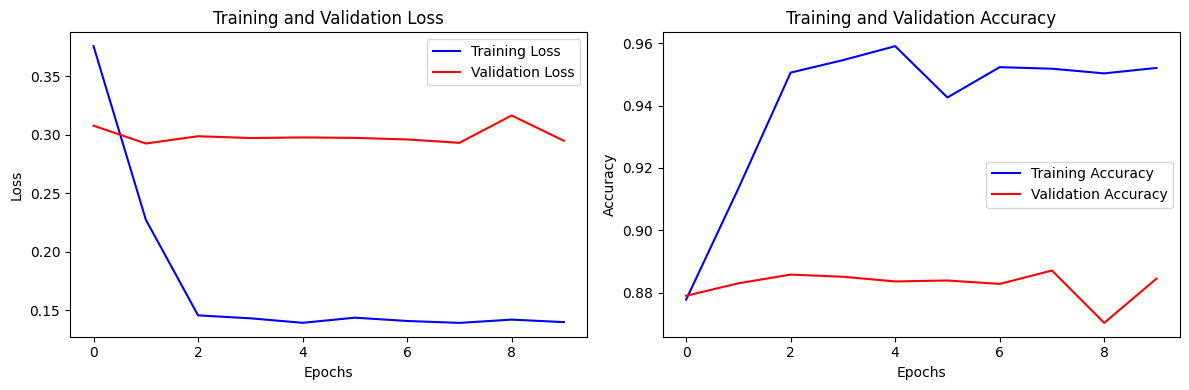

In [31]:
plot_results(epochs, train_accs, train_losses, eval_accs, eval_losses)